# Assignment 17

Lakukan time-series prediction terhadap dataset **Daily Min Temperature** dan **Birth**! Gunakan:
  1. Base model
  2. Deeper model
  3. Wider model
  4. LSTM

Tentukan arsitektur terbaik! Gunakan hyperparameter yang sama dengan yang digunakan secara default seperti contoh diatas untuk perbandingannya.

# Library

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

# Fungsi-Fungsi

In [8]:
# fungsi pada tahap preprocessing
def timeseries_to_supervised(data, lag=1):
  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  return df 

def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

In [19]:
# fungsi plotting loss vs val_loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

# Dataset Daily Min Temperature

In [4]:
def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')

In [5]:
dataset1 = pd.read_csv('drive/My Drive/abc/daily-min-temperatures.csv',
                       header=0, parse_dates=[0], index_col=0, squeeze=True,
                       date_parser=parser)
dataset1.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

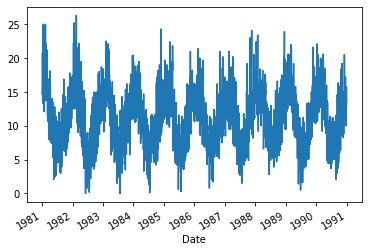

In [6]:
dataset1.plot()
plt.show()

### Preprocessing

In [9]:
lag = 1

raw_values = dataset1.values
diff_values = difference(raw_values, 1)

diff_values

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [10]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [11]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [13]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [15]:
train_scaled

array([[-0.11607143,  0.21428571],
       [ 0.21428571, -0.24107143],
       [-0.24107143,  0.24107143],
       ...,
       [-0.16071429,  0.375     ],
       [ 0.375     ,  0.125     ],
       [ 0.125     , -0.16071429]])

In [16]:
test_scaled

array([[-0.16071429,  0.11607143],
       [ 0.11607143,  0.05357143],
       [ 0.05357143,  0.14285714],
       ...,
       [ 0.09821429,  0.125     ],
       [ 0.125     ,  0.33035714],
       [ 0.33035714, -0.10714286]])

## Baseline Model

In [114]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

bl_model = Sequential()
bl_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
bl_model.add(Dense(1))
bl_model.compile(loss='mean_squared_error', optimizer='adam')
bl_model_history = bl_model.fit(feature_train, label_train, epochs=epoch, 
                                batch_size=batch_size, 
                                validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0669 - val_loss: 0.0559
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0548
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0545
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0543
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0543
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0542
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0542
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0542
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0541
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0541

In [115]:
loss_bl = bl_model.evaluate(feature_test, label_test, verbose=2)

print('Test Loss:', loss_bl)

29/29 - 0s - loss: 0.0540
Test Loss: 0.05399658903479576


In [117]:
bl_history_df = pd.DataFrame(bl_model_history.history)
bl_history_df['epoch'] = bl_model_history.epoch
bl_history_df = bl_history_df.sort_values(by='val_loss', ascending=True)[:3]
bl_history_df['model'] = 'Baseline'
bl_history_df

,loss,val_loss,epoch,model
307,0.058745,0.053976,307,Baseline
799,0.058746,0.053976,799,Baseline
628,0.058757,0.053976,628,Baseline


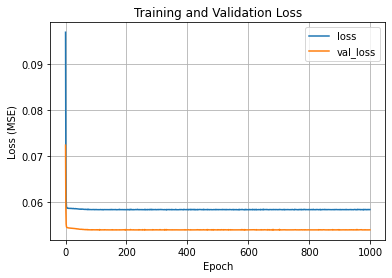

In [23]:
plot_loss(bl_model_history)

## Deeper Model

In [25]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, 
                                        batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0729 - val_loss: 0.0573
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0555
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0552
Epoch 4/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0598 - val_loss: 0.0550
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0550
Epoch 6/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.0549
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0549
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0548
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0548
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0548

In [112]:
deeper_history_df = pd.DataFrame(deeper_model_history.history)
deeper_history_df['epoch'] = deeper_model_history.epoch
deeper_history_df = deeper_history_df.sort_values(by='val_loss', ascending=True)[:3]
deeper_history_df['model'] = 'Deeper'
deeper_history_df

,loss,val_loss,epoch,model
648,0.058279,0.053850,648,Deeper
544,0.058305,0.053851,544,Deeper
771,0.058220,0.053857,771,Deeper


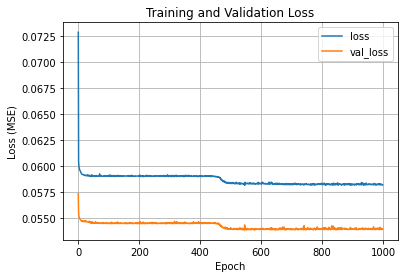

In [27]:
plot_loss(deeper_model_history)

## Wider Model

In [28]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, 
                                      batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0542
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0541
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0543
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0541
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0538
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0538
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0539

In [111]:
wider_history_df = pd.DataFrame(wider_model_history.history)
wider_history_df['epoch'] = wider_model_history.epoch
wider_history_df = wider_history_df.sort_values(by='val_loss', ascending=True)[:3]
wider_history_df['model'] = 'Wider'
wider_history_df

,loss,val_loss,epoch,model
36,0.057984,0.053724,36,Wider
11,0.058272,0.053730,11,Wider
27,0.058018,0.053734,27,Wider


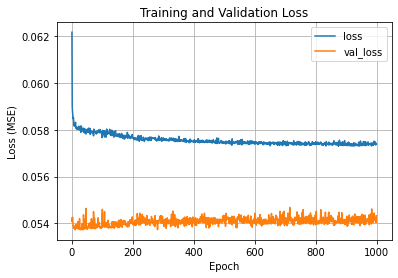

In [30]:
plot_loss(wider_model_history)

## LSTM

In [31]:
epoch = 1000
batch_size = 32

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1,
                                                    feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1,
                                                  feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1]))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch,
                                    batch_size=batch_size, 
                                    validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 1s 6ms/step - loss: 0.0647 - val_loss: 0.0550
Epoch 2/1000
86/86 [==============================] - 0s 6ms/step - loss: 0.0594 - val_loss: 0.0542
Epoch 3/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0589 - val_loss: 0.0542
Epoch 4/1000
86/86 [==============================] - 0s 5ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 6ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 5ms/step - loss: 0.0585 - val_loss: 0.0542
Epoch 7/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0540

In [110]:
lstm_history_df = pd.DataFrame(lstm_model_history.history)
lstm_history_df['epoch'] = lstm_model_history.epoch
lstm_history_df =  lstm_history_df.sort_values(by='val_loss', ascending=True)[:3]
lstm_history_df['model'] = 'LSTM'
lstm_history_df

,loss,val_loss,epoch,model
410,0.057803,0.053739,410,LSTM
431,0.057774,0.053754,431,LSTM
360,0.057841,0.053756,360,LSTM


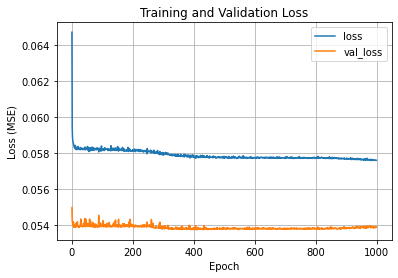

In [33]:
plot_loss(lstm_model_history)

## Kesimpulan

In [120]:
# Dataframe nilai val_loss terkecil masing-masing model 
model1 = [bl_history_df[:1][:], deeper_history_df[:1][:], wider_history_df[:1][:], lstm_history_df[:1][:]]
result1 = pd.concat(model1, ignore_index=True)
result1.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch,model
2,0.057984,0.053724,36,Wider
3,0.057803,0.053739,410,LSTM
1,0.058279,0.053850,648,Deeper
0,0.058745,0.053976,307,Baseline


- Berdasarkan nilai vall_loss terkecil masing-masing model, rata-rata nilainya 0.053 dan train_loss rata-rata 0.057-0.058 sehingga perbedaannya tidak terlalu signifikan.
- Perbedaan dari keempat model tersebut lebih ke epoch saat di sweetspot, dimana model Wider lebih cepat mencapat sweetspot val_loss yaitu di epoch = 36 sedangkan model yang lain di epoch > 300.
- Jadi arsitektur model terbaik dari kasus ini, keseluruhan nya sama bagusnya namun jika dilihat dari kurva kelandaian val_loss, yang mewakili terbaik yaitu model LSTM.
- Prediksi pada kasus ini terbilang bagus (val_loss kecil mencapai 0.05) karena data time series Daily min temperatures ini memiliki tren yang konstan.

# Dataset Birth

In [39]:
def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')

In [40]:
dataset2 = pd.read_csv('drive/My Drive/abc/birth.csv',
                       header=0, parse_dates=[0], index_col=0, squeeze=True,
                       date_parser=parser)
dataset2.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

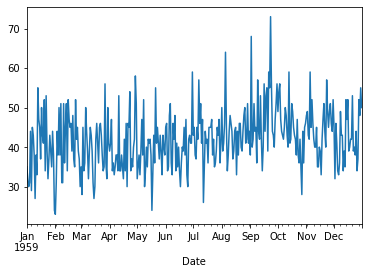

In [41]:
dataset2.plot()
plt.show()

## Preprocessing

In [42]:
lag = 1

raw_values2 = dataset2.values
diff_values2 = difference(raw_values2, 1)

diff_values2

0      -3
1      -2
2       1
3      13
4     -15
       ..
359     3
360    15
361    -4
362     7
363    -5
Length: 364, dtype: int64

In [43]:
supervised2 = timeseries_to_supervised(diff_values2, lag)
supervised2

,0,0
0,NaN,-3
1,-3.0,-2
2,-2.0,1
3,1.0,13
4,13.0,-15
...,...,...
359,-10.0,3
360,3.0,15
361,15.0,-4
362,-4.0,7


In [44]:
supervised_values2 = supervised2.values[lag:,:]
supervised_values2

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [45]:
split_percentage = 0.75

train_size2 = int(split_percentage * len(supervised_values2))

train2, test2 = supervised_values2[0:train_size2], supervised_values2[train_size2:len(supervised_values2)]

In [46]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train)

train_scaled2 = scaler.transform(train2)
test_scaled2 = scaler.transform(test2)

## Baseline Model

In [52]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train2, label_train2 = train_scaled2[:, 0:-1], train_scaled2[:, -1]
feature_test2, label_test2 = test_scaled2[:, 0:-1], test_scaled2[:, -1]

bl_model2 = Sequential()
bl_model2.add(Dense(neurons, activation='relu', input_dim=feature_train2.shape[1]))
bl_model2.add(Dense(1))
bl_model2.compile(loss='mean_squared_error', optimizer='adam')
bl_model_history2 = bl_model2.fit(feature_train2, label_train2, epochs=epoch, 
                                  batch_size=batch_size, 
                                  validation_data=(feature_test2, label_test2))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7034 - val_loss: 0.4520
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.7007 - val_loss: 0.4503
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6983 - val_loss: 0.4488
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.6962 - val_loss: 0.4472
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6942 - val_loss: 0.4459
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6924 - val_loss: 0.4445
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6907 - val_loss: 0.4432
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6890 - val_loss: 0.4418
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6874 - val_loss: 0.4405
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6859 - val_loss: 0.4392
Epoch 11/1000
9/9 

In [53]:
loss_bl2 = bl_model2.evaluate(feature_test2, label_test2, verbose=2)
print('Test Loss:', loss_bl2)

3/3 - 0s - loss: 0.3808
Test Loss: 0.38077402114868164


In [95]:
bl_history_df2 = pd.DataFrame(bl_model_history2.history)
bl_history_df2['epoch'] = bl_model_history2.epoch
bl_history_df2 = bl_history_df2.sort_values(by='val_loss', ascending=True)[:3]
bl_history_df2['model'] = 'Baseline'
bl_history_df2

,loss,val_loss,epoch,model
395,0.584516,0.380311,395,Baseline
394,0.584502,0.380318,394,Baseline
396,0.584517,0.380323,396,Baseline


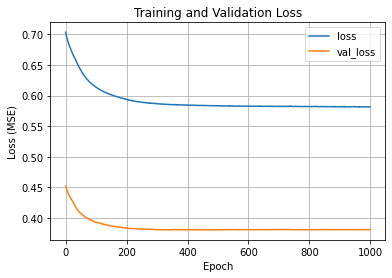

In [55]:
plot_loss(bl_model_history2)

## Deeper Model

In [56]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model2 = Sequential()
deeper_model2.add(Dense(neurons, activation='relu', input_dim=feature_train2.shape[1]))
deeper_model2.add(Dense(5, activation='relu'))
deeper_model2.add(Dense(1))
deeper_model2.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history2 = deeper_model2.fit(feature_train2, label_train2, epochs=epoch, 
                                          batch_size=batch_size, 
                                          validation_data=(feature_test2, label_test2))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7019 - val_loss: 0.4528
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.7006 - val_loss: 0.4523
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6983 - val_loss: 0.4515
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6970 - val_loss: 0.4508
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6959 - val_loss: 0.4500
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6945 - val_loss: 0.4495
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6938 - val_loss: 0.4488
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6927 - val_loss: 0.4482
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6919 - val_loss: 0.4478
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6906 - val_loss: 0.4473
Epoch 11/1000
9/9 

In [57]:
loss_dp2 = deeper_model2.evaluate(feature_test2, label_test2, verbose=2)
print('Test Loss:', loss_dp2)

3/3 - 0s - loss: 0.3640
Test Loss: 0.3640327751636505


In [94]:
deeper_history_df2 = pd.DataFrame(deeper_model_history2.history)
deeper_history_df2['epoch'] = deeper_model_history2.epoch
deeper_history_df2 = deeper_history_df2.sort_values(by='val_loss', ascending=True)[:3]
deeper_history_df2['model'] = 'Deeper'
deeper_history_df2

,loss,val_loss,epoch,model
788,0.547068,0.362244,788,Deeper
870,0.546446,0.362337,870,Deeper
797,0.546849,0.362464,797,Deeper


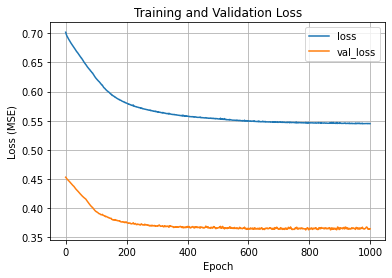

In [59]:
plot_loss(deeper_model_history2)

## Wider Model

In [60]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model2 = Sequential()
wider_model2.add(Dense(neurons, activation='relu', input_dim=feature_train2.shape[1]))
wider_model2.add(Dense(1))
wider_model2.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history2 = wider_model2.fit(feature_train2, label_train2, epochs=epoch, 
                                        batch_size=batch_size, 
                                        validation_data=(feature_test2, label_test2))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.9300 - val_loss: 0.5390
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.8318 - val_loss: 0.4916
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.7618 - val_loss: 0.4564
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.7069 - val_loss: 0.4318
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6677 - val_loss: 0.4141
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6374 - val_loss: 0.4024
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6193 - val_loss: 0.3938
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.6037 - val_loss: 0.3881
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.5940 - val_loss: 0.3840
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.5867 - val_loss: 0.3811
Epoch 11/1000
9/9 

In [61]:
loss_wd2 = wider_model2.evaluate(feature_test2, label_test2, verbose=2)
print('Test Loss:', loss_wd2)

3/3 - 0s - loss: 0.3712
Test Loss: 0.37117311358451843


In [93]:
wider_history_df2 = pd.DataFrame(wider_model_history2.history)
wider_history_df2['epoch'] = wider_model_history2.epoch
wider_history_df2 = wider_history_df2.sort_values(by='val_loss', ascending=True)[:3]
wider_history_df2['model'] = 'Wider'
wider_history_df2

,loss,val_loss,epoch,model
50,0.540773,0.364396,50,Wider
62,0.540157,0.364450,62,Wider
154,0.539232,0.364753,154,Wider


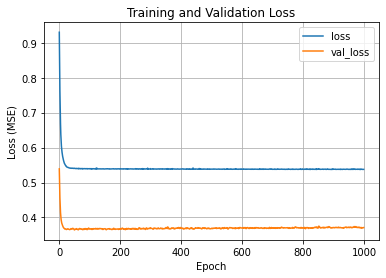

In [63]:
plot_loss(wider_model_history2)

## LSTM

In [64]:
epoch = 1000
batch_size = 32

feature_train_reshaped2 = np.reshape(feature_train2, (feature_train2.shape[0], 1,
                                                    feature_train2.shape[1]))
feature_test_reshaped2 = np.reshape(feature_test2, (feature_test2.shape[0], 1,
                                                  feature_test2.shape[1]))

lstm_model2 = Sequential()
lstm_model2.add(LSTM(50, activation='relu', input_dim=feature_train2.shape[1]))
lstm_model2.add(Dense(1))
lstm_model2.compile(loss='mean_squared_error', optimizer='adam')

lstm_model_history2 = lstm_model2.fit(feature_train_reshaped2, label_train2, epochs=epoch,
                                      batch_size=batch_size, 
                                      validation_data=(feature_test_reshaped2, label_test2))

Epoch 1/1000
9/9 [==============================] - 0s 26ms/step - loss: 0.7761 - val_loss: 0.4833
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.7578 - val_loss: 0.4736
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.7421 - val_loss: 0.4642
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.7274 - val_loss: 0.4552
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.7133 - val_loss: 0.4469
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.7008 - val_loss: 0.4389
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.6868 - val_loss: 0.4314
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.6743 - val_loss: 0.4241
Epoch 9/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.6625 - val_loss: 0.4167
Epoch 10/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.6510 - val_loss: 0.4100
Epoch 11/1000
9/9 

In [65]:
loss_lstm2 = lstm_model2.evaluate(feature_test_reshaped2, label_test2, verbose=2)
print('Test Loss:', loss_lstm2)

3/3 - 0s - loss: 0.3695
Test Loss: 0.3695037364959717


In [107]:
lstm_history_df2 = pd.DataFrame(lstm_model_history2.history)
lstm_history_df2['epoch'] = lstm_model_history2.epoch
lstm_history_df2 = lstm_history_df2.sort_values(by='val_loss', ascending=True)[:3]
lstm_history_df2['model'] = 'LSTM'
lstm_history_df2

,loss,val_loss,epoch,model
30,0.545460,0.363630,30,LSTM
31,0.545092,0.363660,31,LSTM
32,0.544016,0.363673,32,LSTM


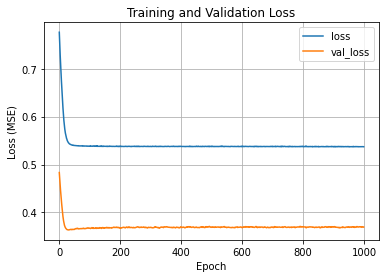

In [67]:
plot_loss(lstm_model_history2)

## Kesimpulan

In [121]:
# Dataframe nilai val_loss terkecil masing-masing model 
model2 = [bl_history_df2[:1][:], deeper_history_df2[:1][:], wider_history_df2[:1][:], lstm_history_df2[:1][:]]
result2 = pd.concat(model2, ignore_index=True)
result2.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch,model
1,0.547068,0.362244,788,Deeper
3,0.545460,0.363630,30,LSTM
2,0.540773,0.364396,50,Wider
0,0.584516,0.380311,395,Baseline


- Berdasarkan nilai vall_loss terkecil masing-masing model, rata-rata nilainya 0.36 kecuali model Baseline yaitu 0.38 namun perbedaan tersebut tidak terlalu signifikan.
- Perbedaan dari keempat model tersebut lebih ke epoch saat di sweetspot, dimana model LSTM dan Wider lebih cepat mencapat sweetspot val_loss yaitu LSTM epoch = 30 dan Wider epoch = 50.
- Jadi arsitektur model terbaik jika dipilih salah satu yaitu model LSTM.
- Prediksi pada kasus ini terbilang kurang bagus (val_loss lumayan besar mencapai 0.3) karena data time series Birth ini memiliki tren yang kurang konstan.